In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials

from plotnine import *

warnings.filterwarnings('ignore')

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql


def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [85]:
def get_gini(df, val_col, group_key = None, color = "red", plot_tf = True) :
    '''
    gini 계수 및 그래프(로렌츠커브)를 그려주는 함수
    df : 지니 계수를 뽑을 데이터프레임 -- pd.DataFrame
    val_col : 지니 계수 대상 컬럼명 -- str
    group_key : 로렌츠커브 그룹화할(컬러를 다르게 지정할) 컬럼명 -- str, default = None
    color  : 로렌츠커브를 나타낼 막대의 색깔 -- str, default = "red"
    plot_tf : 로렌츠커브 프린트에 대한 boolean -- boolean, default = True
    '''
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    if group_key == None :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6)
    else :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio", fill = group_key), alpha = 0.6)

    if plot_tf == True :

        print((
            ggplot(data = tmp) +
            col_plot +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))

        
    
    return (tri - lorenz) / tri

def ad_active(df, d) :
    return (df.adorders_start_date <= d) & (df.adorders_end_date >= d) & ~((df.pauseHistory_startAt_date <= d) & (df.pauseHistory_endAt_date >= d)) & (df.adorders_status == 'apply') & (df.adpayments_status == 'paid')

def ad_active_dates(df, date_list) :
    return pd.concat([df[ad_active(df, d)] for d in date_list]).drop_duplicates()

def prefix_rnk(df, str_cols, y_cols, zfill_ns = 2) :
    return df[y_cols].rank(ascending = False).astype(int).astype(str).str.zfill(zfill_ns) + "_" + df[str_cols]

In [29]:
adorder_with_tag = bigquery_to_pandas(read_bql("../bql/adorder_with_tag.bql"))

In [59]:
adorder_with_tag = adorder_with_tag.sort_values(["slug", "tag_createdAt"]).drop_duplicates(subset = ["adCategory_name", "slug"], keep = "last")

In [60]:
adorder_with_tag[adorder_with_tag.tags.notna()].lawyer.nunique() / adorder_with_tag.lawyer.nunique()

0.3045356371490281

In [94]:
advice = bigquery_to_pandas(read_bql("../bql/advice_query.bql"))
# adorders = bigquery_to_pandas(read_bql("../bql/adorders_query.bql"))

In [95]:
bdate_range = pd.date_range(datetime.date(2022, 8, 16), datetime.date(2022, 8, 22))
adate_range = pd.date_range(datetime.date(2022, 8, 23), datetime.date(2022, 8, 31))

In [96]:
# extract_adorders = ad_active_dates(adorders, date_range)
bextract_advice = advice[(advice.createdAt.dt.date.isin(bdate_range.date))]
aextract_advice = advice[(advice.createdAt.dt.date.isin(adate_range.date))]

In [97]:
bextract_advice = pd.merge(bextract_advice, adorder_with_tag[["lawyer", "slug"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")
aextract_advice = pd.merge(aextract_advice, adorder_with_tag[["lawyer", "slug", "tags"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")

In [98]:
extract_advice = pd.concat([bextract_advice.assign(tp = "b"), aextract_advice.assign(tp = "a")])

In [99]:
extract_advice = extract_advice.assign(tags_exist = lambda x : np.where(x.tags.notna(), "t", "n"))

In [100]:
extract_advice = extract_advice.sort_values(["_id", ]).drop_duplicates(subset = ["_id", "slug", "tp"])

In [106]:
extract_advice[extract_advice.slug == '8005-조대진']

,_id,lawyer_id,adCategory,createdAt,status,adCategory_name,lawyer,slug,tp,tags,tags_exist
16015,62fb045bc5ddd300fb79c783,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 02:43:39.781000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
25190,62fb0b5ccc76940020674d04,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 03:13:32.012000+00:00,reserved,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
15840,62fb1be8dda4be005b0556ca,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 04:24:08.551000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
15520,62fb3587a8ace20035505649,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 06:13:27.952000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
16083,62fb3e3ab33d7200c18109e7,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 06:50:34.579000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
...,...,...,...,...,...,...,...,...,...,...,...
26534,630d56517d622f01e1c28340,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 00:14:09.241000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,"방송,당신과함께",t
27325,630d646d92bad800a1b6d037,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 01:14:21.310000+00:00,reserved,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,None,n
27251,630d6893408426040a18b864,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 01:32:03.269000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,"방송,언론",t
25802,630d707c27c3ac00c15a0e57,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 02:05:48.559000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,None,n


강조태그 전 상담 변호사수 : 311
강조태그 전 상담 수 : 3020
       slug tags_exist  _id
0  8005-조대진  n          88 
1  9403-김현중  n          61 
2  9054-박성현  n          60 
3  9101-김형민  n          49 
4  0106-하진규  n          48 


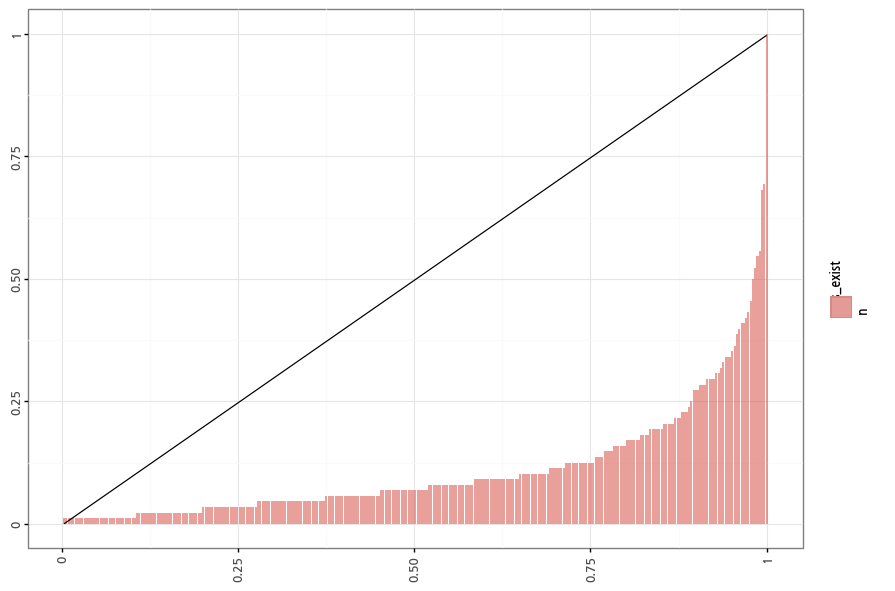


강조 태그 전 분야 불평등도 = 0.8324735716101538


In [101]:
print("강조태그 전 상담 변호사수 : {}".format(extract_advice[extract_advice.tp == "b"].lawyer_id.nunique()))
print("강조태그 전 상담 수 : {}".format(extract_advice[extract_advice.tp == "b"]._id.nunique()))

print(extract_advice[extract_advice.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
print("강조 태그 전 분야 불평등도 = {}".format(get_gini(extract_advice[extract_advice.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))

In [107]:
extract_advice[extract_advice.slug == '8005-조대진']

,_id,lawyer_id,adCategory,createdAt,status,adCategory_name,lawyer,slug,tp,tags,tags_exist
16015,62fb045bc5ddd300fb79c783,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 02:43:39.781000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
25190,62fb0b5ccc76940020674d04,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 03:13:32.012000+00:00,reserved,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
15840,62fb1be8dda4be005b0556ca,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 04:24:08.551000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
15520,62fb3587a8ace20035505649,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 06:13:27.952000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
16083,62fb3e3ab33d7200c18109e7,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-16 06:50:34.579000+00:00,complete,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,b,NaN,n
...,...,...,...,...,...,...,...,...,...,...,...
26534,630d56517d622f01e1c28340,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 00:14:09.241000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,"방송,당신과함께",t
27325,630d646d92bad800a1b6d037,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 01:14:21.310000+00:00,reserved,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,None,n
27251,630d6893408426040a18b864,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 01:32:03.269000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,"방송,언론",t
25802,630d707c27c3ac00c15a0e57,5f18074b8ff5d801a4ac97f0,62b15d031d9a55e41f52c6ff,2022-08-30 02:05:48.559000+00:00,reservation,기타,5f18074b8ff5d801a4ac97f0,8005-조대진,a,None,n


In [109]:
tmp = extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index()

In [110]:
tmp[tmp.slug == '8005-조대진']

,slug,tags_exist,_id
0,8005-조대진,n,79
72,8005-조대진,t,13


강조태그 전 상담 변호사수 : 323
강조태그 전 상담 수 : 3275
       slug tags_exist  _id
0  8005-조대진  n          79 
1  9403-김현중  t          69 
2  2359-이재희  t          64 
3  9054-박성현  t          48 
4  0238-김준환  t          46 


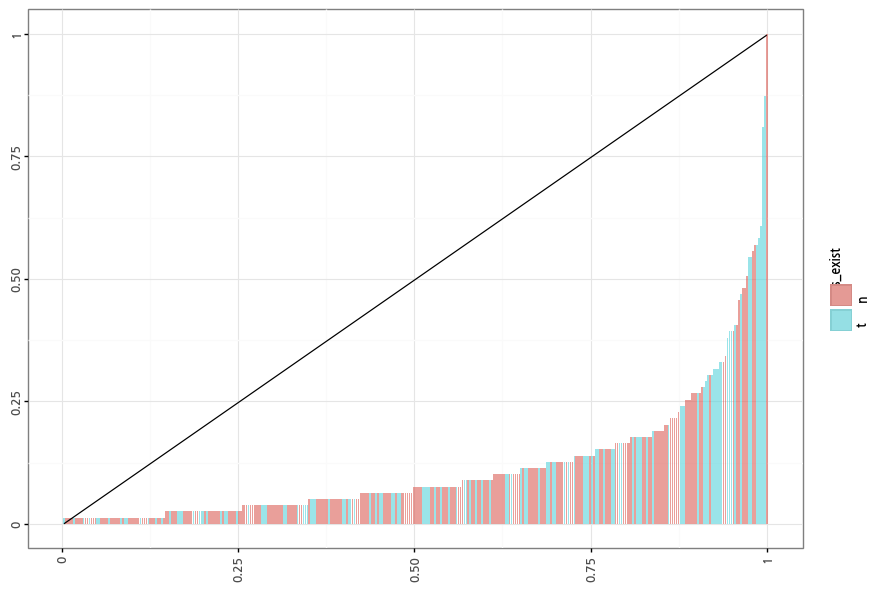


강조 태그 전 분야 불평등도 = 0.8234625032865661


In [104]:
print("강조태그 전 상담 변호사수 : {}".format(extract_advice[extract_advice.tp == "a"].lawyer_id.nunique()))
print("강조태그 전 상담 수 : {}".format(extract_advice[extract_advice.tp == "a"]._id.nunique()))

print(extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
print("강조 태그 전 분야 불평등도 = {}".format(get_gini(extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))

In [90]:
# extract_adorders = ad_active_dates(adorders, date_range)
bextract_advice = advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(bdate_range.date))]
aextract_advice = advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(adate_range.date))]

In [64]:
bextract_advice = pd.merge(bextract_advice, adorder_with_tag[["lawyer", "slug"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")
aextract_advice = pd.merge(aextract_advice, adorder_with_tag[["lawyer", "slug", "tags"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")

In [79]:
extract_advice = pd.concat([bextract_advice.assign(tp = "b"), aextract_advice.assign(tp = "a")])

In [80]:
extract_advice = extract_advice.assign(tags_exist = lambda x : np.where(x.tags.notna(), "t", "n"))

In [81]:
extract_advice = extract_advice.sort_values(["_id", ]).drop_duplicates(subset = ["_id", "slug", "tp"])

임대차 분야
강조태그 전 상담 변호사수 : 46
강조태그 후 상담 변호사수 : 45
강조태그 전 상담 수 : 164
강조태그 후 상담 수 : 138
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  7467-정동운  n          14 
1  5258-이광석  n          13 
2  5015-한병진  n          11 
3  8057-강동호  n          9  
4  5129-전문영  n          8  


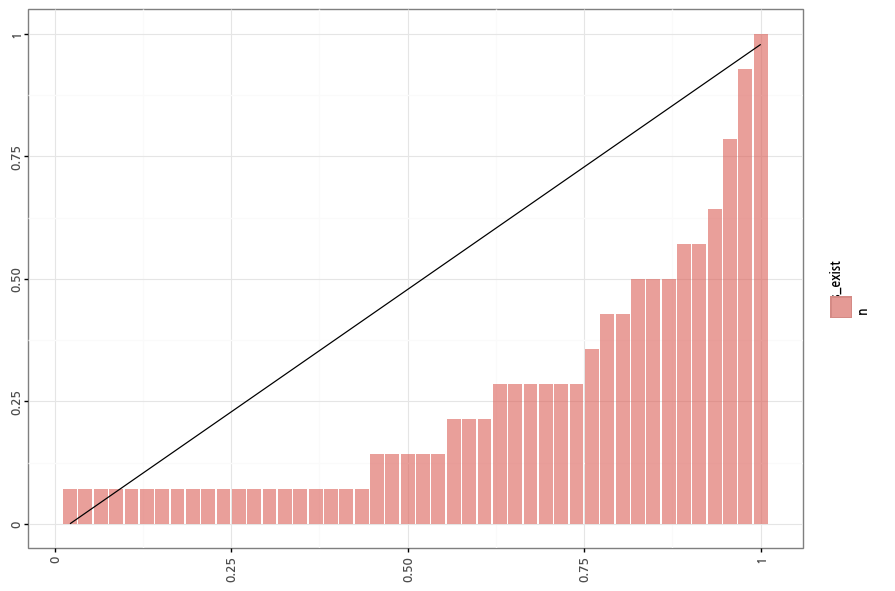


임대차 강조 태그 전 분야 불평등도 = 0.6195652173913043
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  5258-이광석  n          11 
1  5225-임영호  t          10 
2  2581-오현석  n          9  
3  5018-김수한  t          8  
4  5015-한병진  n          8  


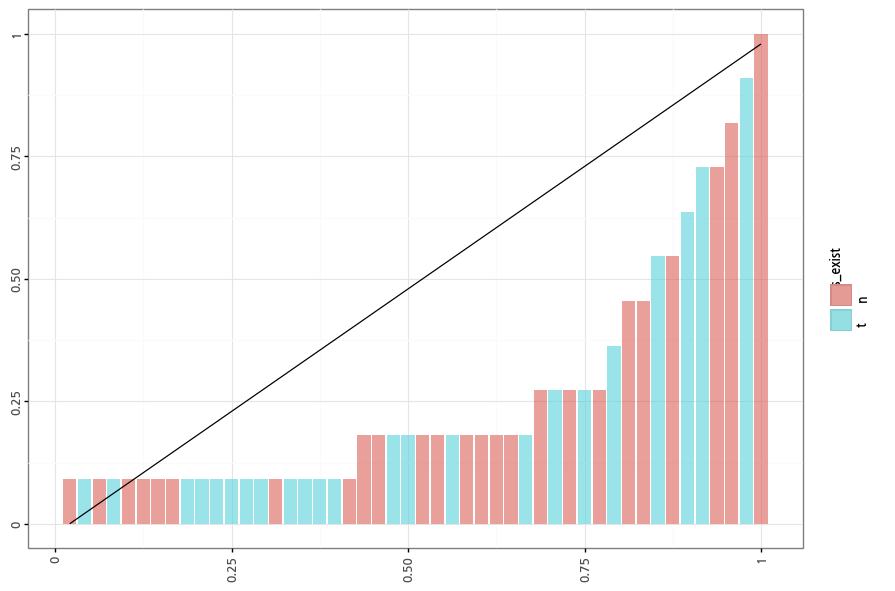


임대차 강조 태그 후 분야 불평등도 = 0.6179766414141414



--------------------------------------------------
손해배상 분야
강조태그 전 상담 변호사수 : 63
강조태그 후 상담 변호사수 : 57
강조태그 전 상담 수 : 127
강조태그 후 상담 수 : 108
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  0208-서지원  n          14 
1  9420-김장천  n          9  
2  5018-김수한  n          6  
3  2355-이현웅  n          4  
4  8800-정대식  n          4  


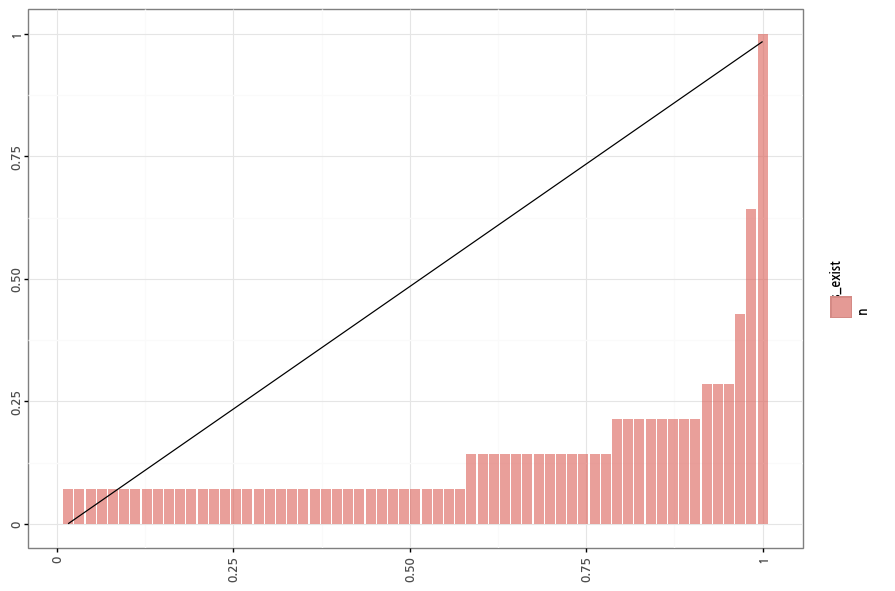


손해배상 강조 태그 전 분야 불평등도 = 0.7990857718748875
강조태그 릴리즈 후 상위 5 변호사 상담 건수
        slug tags_exist  _id
0  0208-서지원   t          10 
1  9420-김장천   n          6  
2  2085-최한겨레  n          4  
3  9536-장지원   t          4  
4  5447-서아람   t          3  


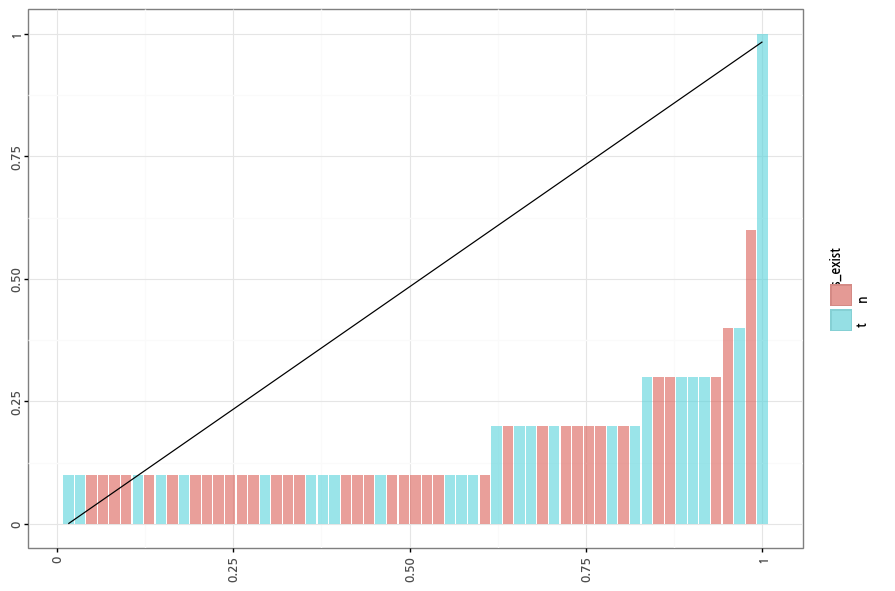


손해배상 강조 태그 후 분야 불평등도 = 0.7624832034399355



--------------------------------------------------
디지털 성범죄 분야
강조태그 전 상담 변호사수 : 47
강조태그 후 상담 변호사수 : 46
강조태그 전 상담 수 : 106
강조태그 후 상담 수 : 117
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  9340-옥민석  n          15 
1  5005-고광욱  n          6  
2  9101-김형민  n          5  
3  5168-이충용  n          4  
4  2373-박준성  n          4  


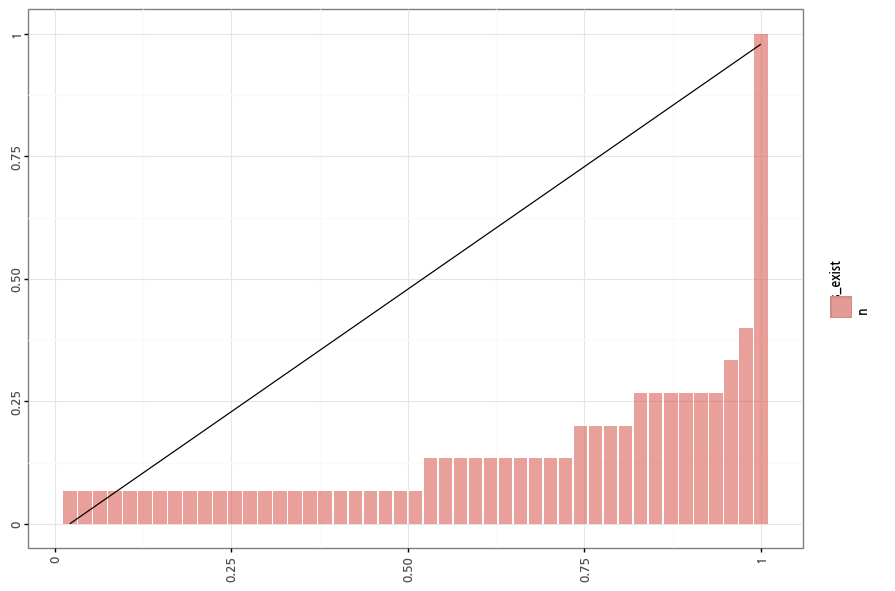


디지털 성범죄 강조 태그 전 분야 불평등도 = 0.7869322468688698
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  2373-박준성  t          10 
1  2847-김정중  n          9  
2  9340-옥민석  n          7  
3  8805-이진석  n          7  
4  9054-박성현  t          5  


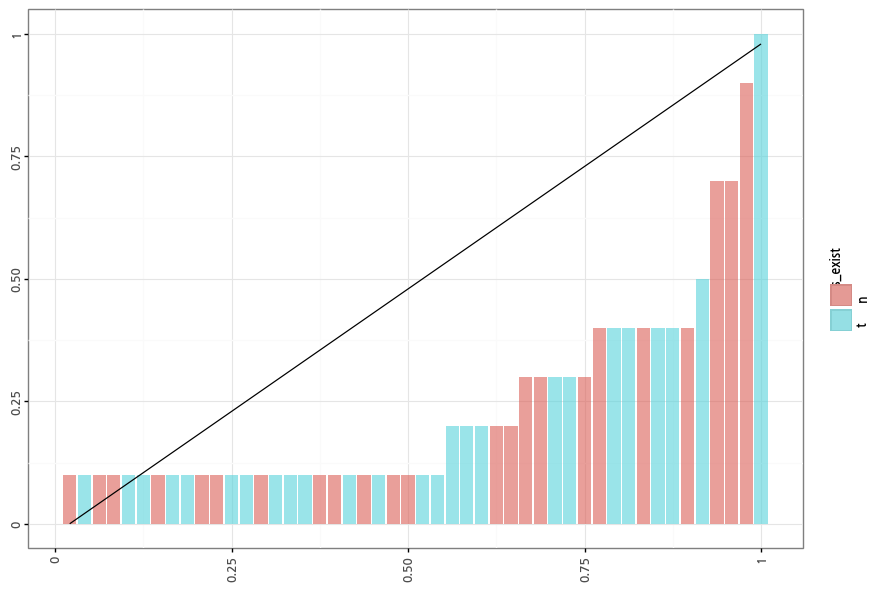


디지털 성범죄 강조 태그 후 분야 불평등도 = 0.6500868055555555



--------------------------------------------------
폭행/협박/상해 일반 분야
강조태그 전 상담 변호사수 : 57
강조태그 후 상담 변호사수 : 51
강조태그 전 상담 수 : 110
강조태그 후 상담 수 : 99
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  0208-서지원  n          10 
1  8562-장현경  n          10 
2  0678-정현우  n          7  
3  9054-박성현  n          7  
4  8080-김지원  n          4  


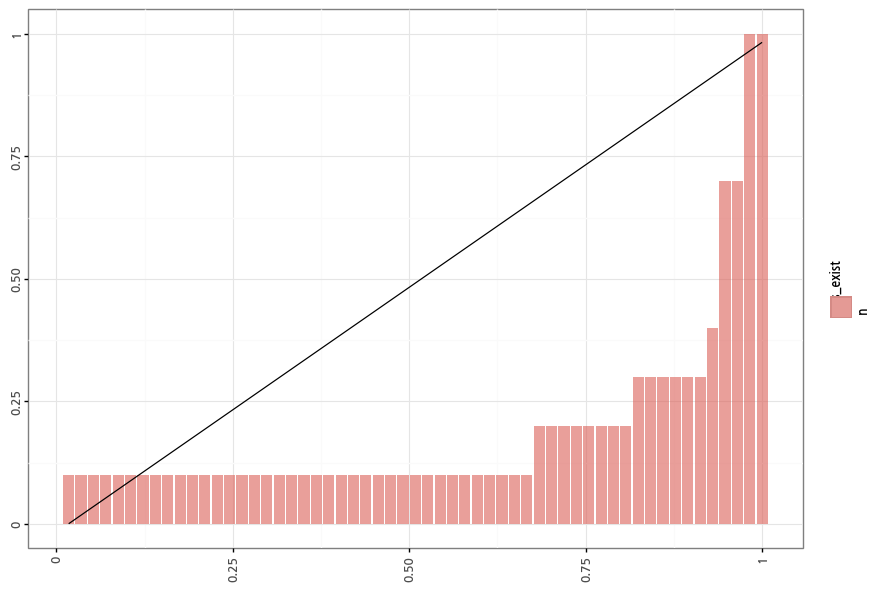


폭행/협박/상해 일반 강조 태그 전 분야 불평등도 = 0.7281009541397353
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  2359-이재희  t          6  
1  0811-안영림  n          5  
2  9054-박성현  t          5  
3  8562-장현경  n          5  
4  0949-노우상  n          4  


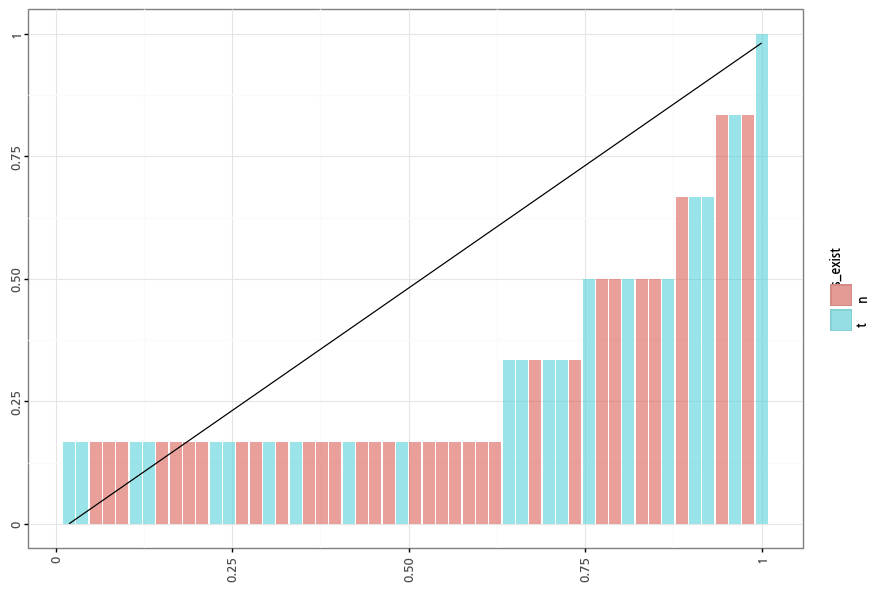


폭행/협박/상해 일반 강조 태그 후 분야 불평등도 = 0.5774296902812389



--------------------------------------------------
형사일반/기타범죄 분야
강조태그 전 상담 변호사수 : 61
강조태그 후 상담 변호사수 : 42
강조태그 전 상담 수 : 107
강조태그 후 상담 수 : 83
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  9054-박성현  n          11 
1  5132-김유진  n          6  
2  5070-김현귀  n          6  
3  0866-정지원  n          5  
4  5447-서아람  n          4  


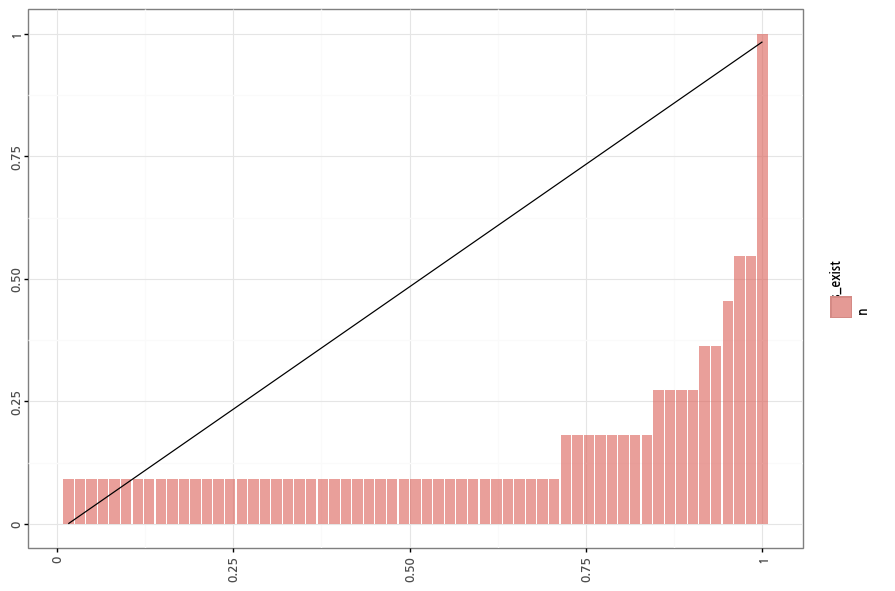


형사일반/기타범죄 강조 태그 전 분야 불평등도 = 0.781339327160343
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  5447-서아람  t          8  
1  0866-정지원  n          7  
2  5132-김유진  t          5  
3  9687-박도민  n          4  
4  9162-백창협  n          4  


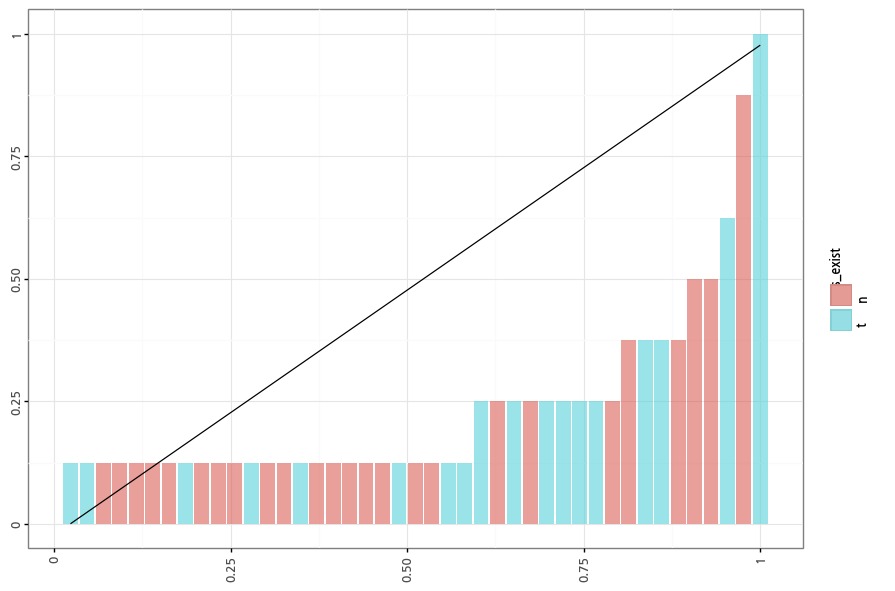


형사일반/기타범죄 강조 태그 후 분야 불평등도 = 0.6671173607355327



--------------------------------------------------
이혼 분야
강조태그 전 상담 변호사수 : 44
강조태그 후 상담 변호사수 : 37
강조태그 전 상담 수 : 113
강조태그 후 상담 수 : 76
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  0724-고순례  n          9  
1  0899-전효중  n          9  
2  0866-정지원  n          7  
3  9321-유지은  n          7  
4  9288-김수경  n          6  


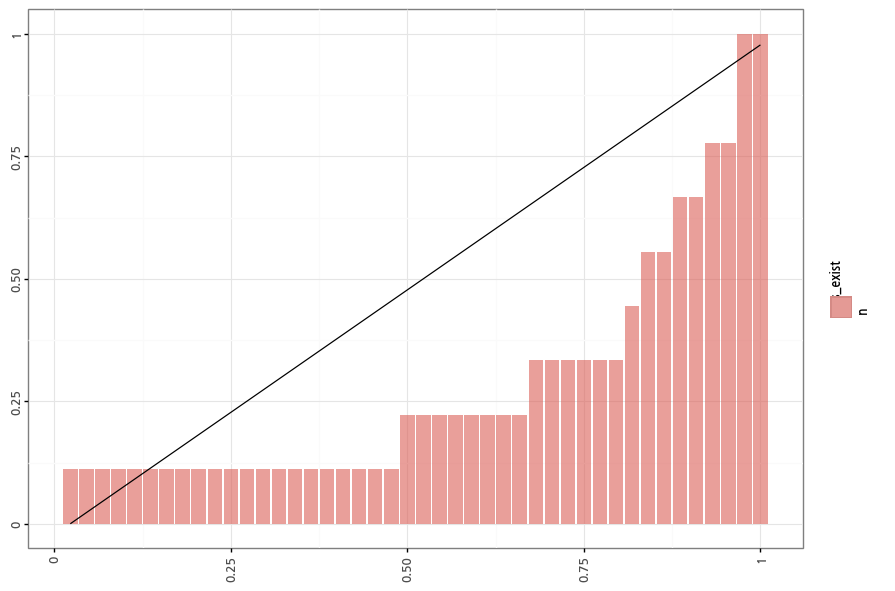


이혼 강조 태그 전 분야 불평등도 = 0.5889577594123049
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  0866-정지원  n          9  
1  5200-조유라  n          5  
2  0724-고순례  n          5  
3  0899-전효중  t          5  
4  0119-노경희  n          4  


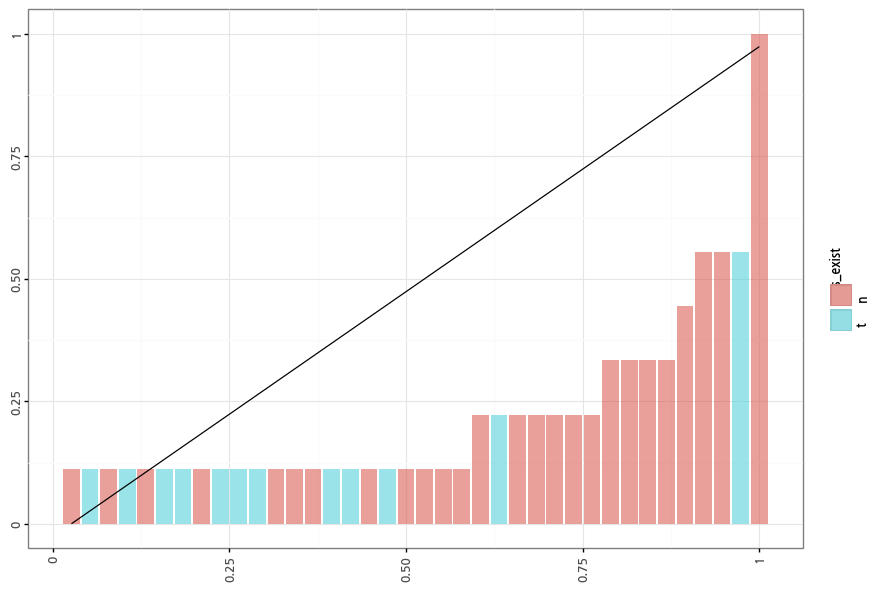


이혼 강조 태그 후 분야 불평등도 = 0.6902123730378578



--------------------------------------------------
성폭력/강제추행 등 분야
강조태그 전 상담 변호사수 : 50
강조태그 후 상담 변호사수 : 40
강조태그 전 상담 수 : 102
강조태그 후 상담 수 : 72
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  2249-김지진  n          10 
1  8801-하나   n          7  
2  7673-심지연  n          6  
3  8569-이고은  n          6  
4  2611-서명기  n          5  


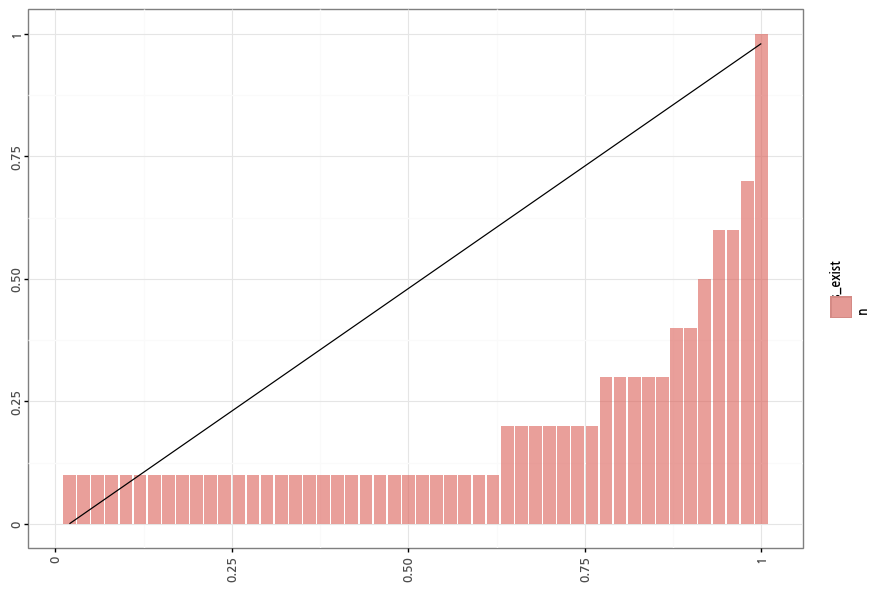


성폭력/강제추행 등 강조 태그 전 분야 불평등도 = 0.7120000000000001
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  9054-박성현  t          7  
1  2249-김지진  n          6  
2  0820-심강현  t          4  
3  5447-서아람  t          3  
4  0678-정현우  t          3  


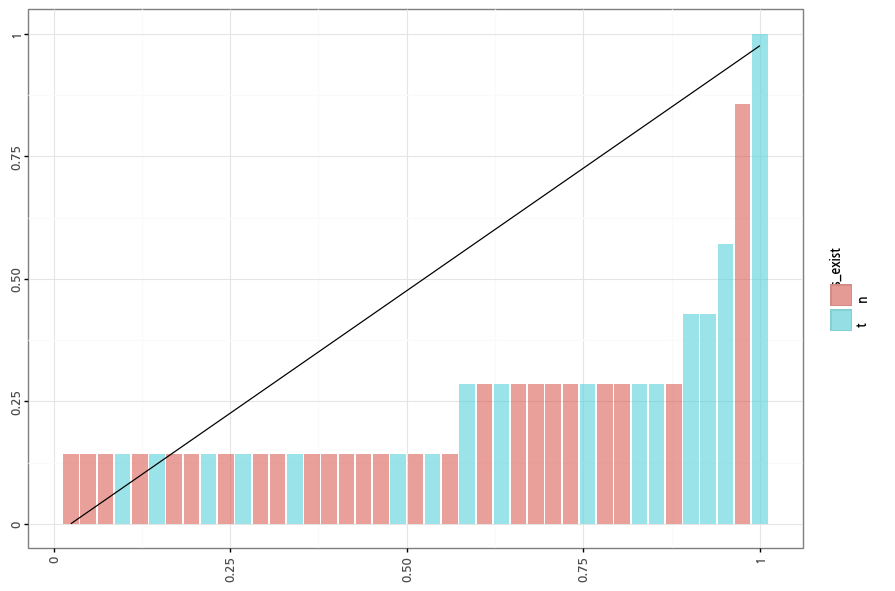


성폭력/강제추행 등 강조 태그 후 분야 불평등도 = 0.6661850939066882



--------------------------------------------------
사기/공갈 분야
강조태그 전 상담 변호사수 : 48
강조태그 후 상담 변호사수 : 43
강조태그 전 상담 수 : 88
강조태그 후 상담 수 : 77
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  9403-김현중  n          8  
1  9536-장지원  n          5  
2  9054-박성현  n          5  
3  2803-권재성  n          4  
4  2847-김정중  n          3  


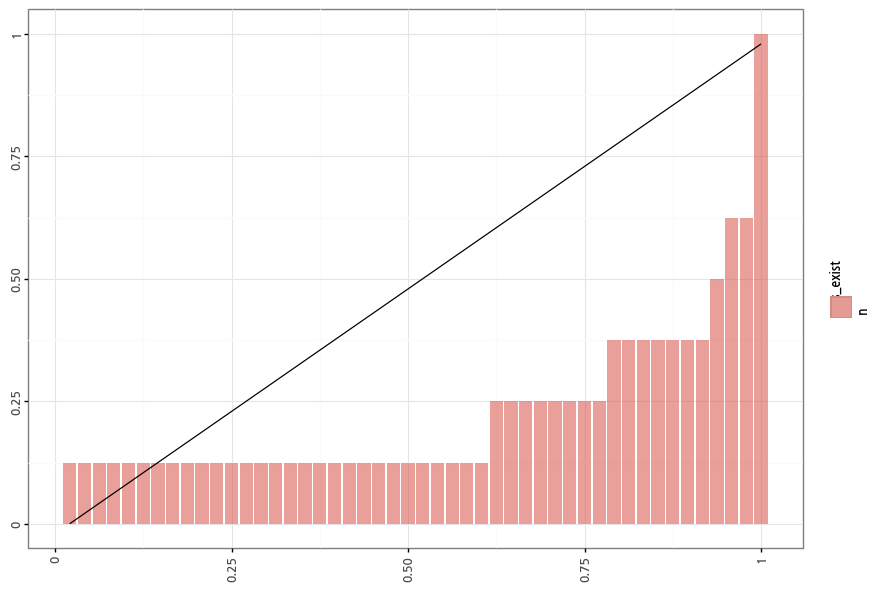


사기/공갈 강조 태그 전 분야 불평등도 = 0.6895616319444445
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  9403-김현중  t          6  
1  2847-김정중  n          5  
2  2803-권재성  n          4  
3  5447-서아람  t          4  
4  2991-박정민  t          4  


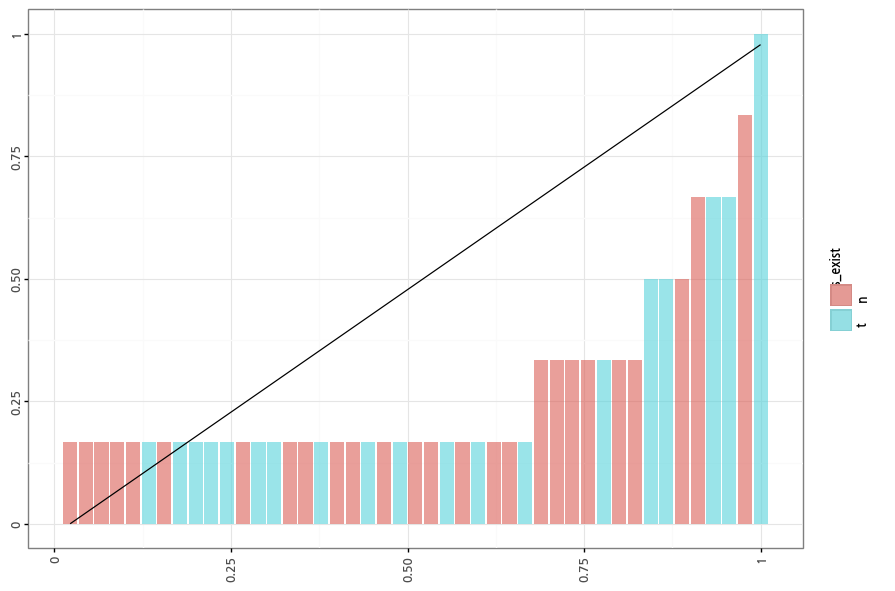


사기/공갈 강조 태그 후 분야 불평등도 = 0.6237037037037038



--------------------------------------------------
계약일반/매매 분야
강조태그 전 상담 변호사수 : 41
강조태그 후 상담 변호사수 : 47
강조태그 전 상담 수 : 77
강조태그 후 상담 수 : 84
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  2611-서명기  n          10 
1  2874-연취현  n          5  
2  0857-황성준  n          5  
3  9088-이지영  n          5  
4  5036-최기영  n          4  


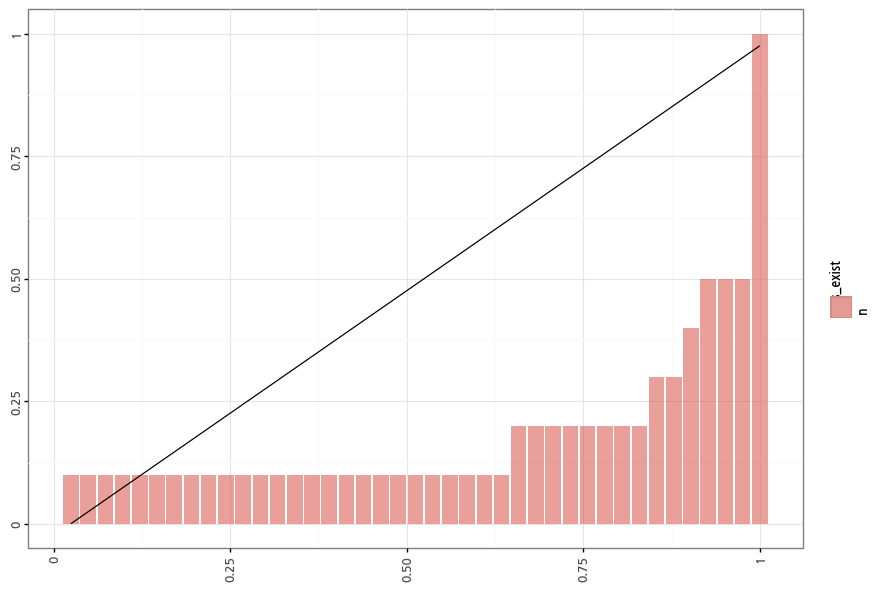


계약일반/매매 강조 태그 전 분야 불평등도 = 0.7388459250446163
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  2581-오현석  n          5  
1  2756-최유정  t          4  
2  9088-이지영  t          4  
3  2611-서명기  n          4  
4  0120-서용진  t          3  


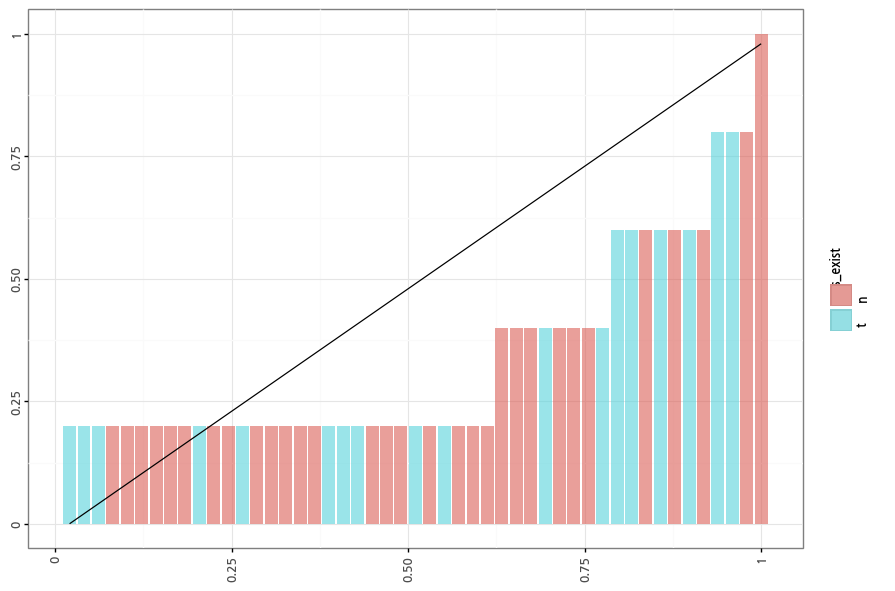


계약일반/매매 강조 태그 후 분야 불평등도 = 0.5488546438983757



--------------------------------------------------
사이버 명예훼손/모욕 분야
강조태그 전 상담 변호사수 : 35
강조태그 후 상담 변호사수 : 24
강조태그 전 상담 수 : 91
강조태그 후 상담 수 : 69
강조태그 릴리즈 전 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  8562-장현경  n          8  
1  2991-박정민  n          7  
2  5126-이승우  n          7  
3  5116-안선모  n          6  
4  0578-김원석  n          6  


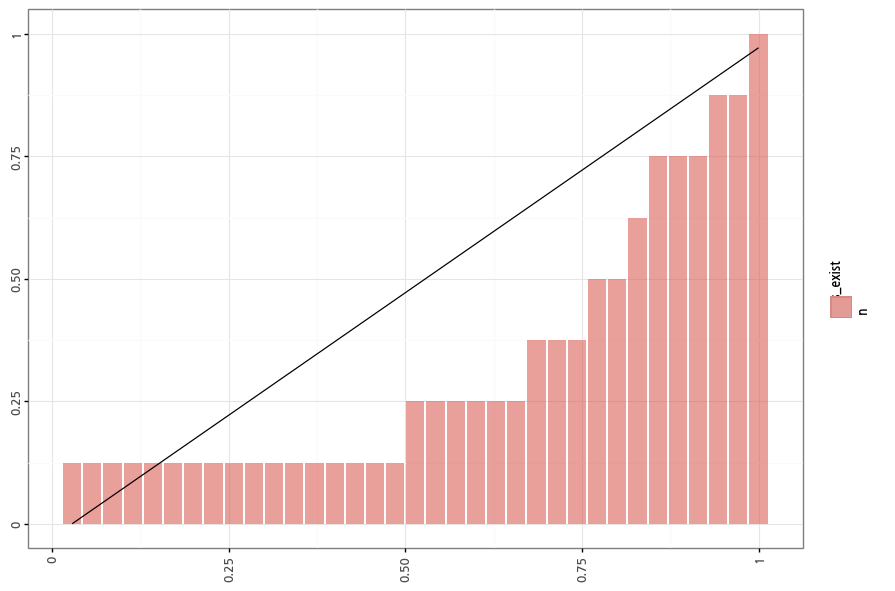


사이버 명예훼손/모욕 강조 태그 전 분야 불평등도 = 0.5314285714285715
강조태그 릴리즈 후 상위 5 변호사 상담 건수
       slug tags_exist  _id
0  7525-강지웅  t          10 
1  2359-이재희  t          7  
2  2991-박정민  t          5  
3  0578-김원석  n          4  
4  0815-이정석  t          4  


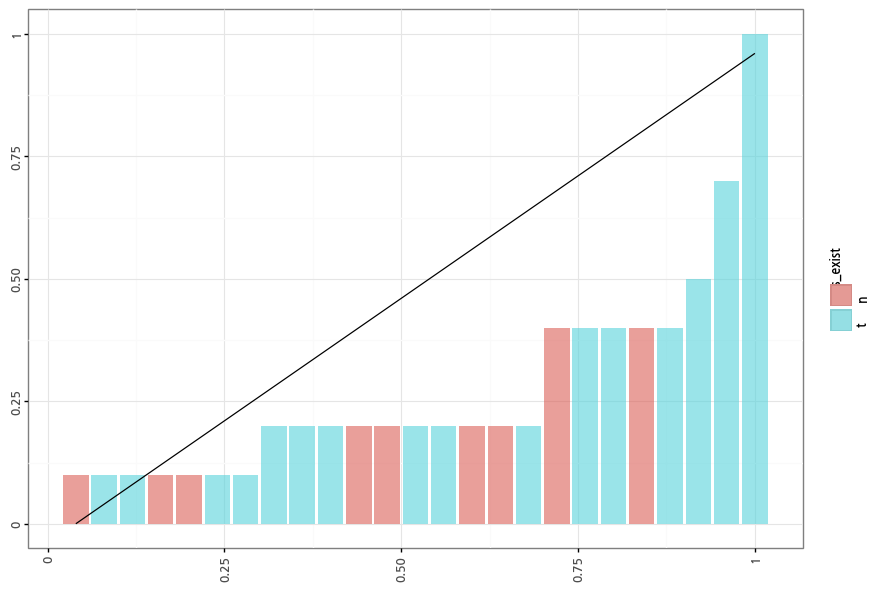


사이버 명예훼손/모욕 강조 태그 후 분야 불평등도 = 0.61248



--------------------------------------------------


In [84]:
for idx, i in enumerate(extract_advice.groupby("adCategory_name")._id.count().sort_values(ascending = False).index[:10]) :
    
    print(f"{i} 분야")
    
    chk1 = extract_advice[extract_advice.adCategory_name == i]
    
    print("강조태그 전 상담 변호사수 : {}".format(chk1[chk1.tp == "b"].lawyer_id.nunique()))
    print("강조태그 후 상담 변호사수 : {}".format(chk1[chk1.tp == "a"].lawyer_id.nunique()))
    
    print("강조태그 전 상담 수 : {}".format(chk1[chk1.tp == "b"]._id.nunique()))
    print("강조태그 후 상담 수 : {}".format(chk1[chk1.tp == "a"]._id.nunique()))

    print("강조태그 릴리즈 전 상위 5 변호사 상담 건수")
    print(chk1[chk1.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
    print("{} 강조 태그 전 분야 불평등도 = {}".format(i, get_gini(chk1[chk1.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))
    
    print("강조태그 릴리즈 후 상위 5 변호사 상담 건수")
    print(chk1[chk1.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
    print("{} 강조 태그 후 분야 불평등도 = {}".format(i, get_gini(chk1[chk1.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))
    
    print("\n"*2)
    print("-"*50) 